In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt


from matplotlib.ticker import FuncFormatter
import folium
from folium import plugins
import seaborn as sns

%matplotlib inline

from opencage.geocoder import OpenCageGeocode

In [2]:
season_stats = pd.read_csv('nba-players-stats/seasons_stats.csv').iloc[:,1:]
players = pd.read_csv('nba-players-stats/players.csv').iloc[:,1:]
player_data = pd.read_csv('nba-players-stats/player_data.csv')
player_data.loc[2142, ['position', 'height', 'weight']] = ['G', '6-2', '190'] ### values manually added from online

In [3]:
player_data.head()

,name,year_start,year_end,position,height,weight,birth_date,college
0,Alaa Abdelnaby,1991,1995,F-C,6-10,240,"June 24, 1968",Duke University
1,Zaid Abdul-Aziz,1969,1978,C-F,6-9,235,"April 7, 1946",Iowa State University
2,Kareem Abdul-Jabbar,1970,1989,C,7-2,225,"April 16, 1947","University of California, Los Angeles"
3,Mahmoud Abdul-Rauf,1991,2001,G,6-1,162,"March 9, 1969",Louisiana State University
4,Tariq Abdul-Wahad,1998,2003,F,6-6,223,"November 3, 1974",San Jose State University


In [4]:
pos_height_by_year = defaultdict(dict)
for i in range(min(player_data.year_start), max(player_data.year_end)+1):
    pos_height_by_year[i] = {'G':[], 'F':[], 'C':[], 'All':[]}

for ind,row in player_data.iterrows():
    for year in range(row['year_start'], row['year_end']+1):
        height = row['height']
        for pos in row['position'].split('-'):
            pos_height_by_year[year][pos].append(int(height[0])*12+int(height[2]))
        pos_height_by_year[year]['All'].append(int(height[0])*12+int(height[2]))

In [5]:
years = range(min(player_data.year_start), max(player_data.year_end)+1)

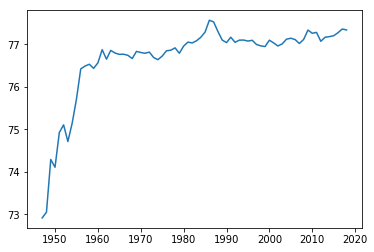

In [6]:
fig = plt.figure()
plt.plot(years, [np.mean(pos_height_by_year[x]['All']) for x in years])

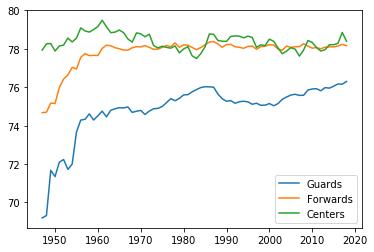

In [7]:
fig = plt.figure()

plt.plot(years, [np.mean(pos_height_by_year[x]['G']) for x in years], label ='Guards')
plt.plot(years, [np.mean(pos_height_by_year[x]['F']) for x in years], label ='Forwards')
plt.plot(years, [np.mean(pos_height_by_year[x]['C']) for x in years], label ='Centers')
plt.legend()

## Location Gathering

In [ ]:
places = (players.birth_city + ', ' + players.birth_state).dropna().reset_index(drop=True).unique()

In [ ]:
places

In [ ]:
from opencage.geocoder import OpenCageGeocode

In [ ]:
api_key = '' #'563806c2a16e4672880fc37af089bc57'

In [ ]:
geocoder = OpenCageGeocode(api_key)

In [ ]:
lat_lst = []
lng_lst = []
continent_lst = []
country_lst = []


for ind, i in enumerate(places):
    try:
        location = geocoder.geocode(i)
        lat_lst.append(location[0]['geometry']['lat'])
        lng_lst.append(location[0]['geometry']['lng'])
        continent_lst.append(location[0]['components']['continent'])
        country_lst.append(location[0]['components']['country'])
    except:
        print(ind)
        break
    

In [ ]:
#### orefield, pennsylvania since it broke there (index 640)

lat_lst.append(40.6350)
lng_lst.append(75.5849)
continent_lst.append('North America')
country_lst.append('USA')

In [ ]:
for ind, i in enumerate(places[641:], 641):
    try:
        location = geocoder.geocode(i)
        lat_lst.append(location[0]['geometry']['lat'])
        lng_lst.append(location[0]['geometry']['lng'])
        continent_lst.append(location[0]['components']['continent'])
        country_lst.append(location[0]['components']['country'])
    except:
        print(ind)
        break

In [ ]:
##### 'Venado Tuerto, Argentina' index (1123)

lat_lst.append(33.7456)
lng_lst.append(61.9690)
continent_lst.append('South America')
country_lst.append('Argentina')

In [ ]:
for ind, i in enumerate(places[1124:], 1124):
    try:
        location = geocoder.geocode(i)
        lat_lst.append(location[0]['geometry']['lat'])
        lng_lst.append(location[0]['geometry']['lng'])
        continent_lst.append(location[0]['components']['continent'])
        country_lst.append(location[0]['components']['country'])
    except:
        print(ind)
        break

In [ ]:
# location_df = pd.DataFrame({'Place' : places, 'Lat': lat_lst, 'Long':lng_lst, 
#                             'Continents':continent_lst, 'Country' : country_lst})
# location_df.to_csv('City_Locations.csv', index=False)

## Locations to Players

In [8]:
location_df = pd.read_csv('nba-players-stats/City_Locations.csv')

In [9]:
players.loc[:,'birth'] = players.loc[:,'birth_city'] + ", " +  players.loc[:,'birth_state']

In [10]:
players_with_location= pd.merge(players, location_df, left_on='birth', right_on='Place', how='left').drop('Place', axis=1)

## Location Geomap

In [11]:
m = folium.Map([30, 0], zoom_start=2)

In [14]:
seasons_with_location = pd.merge(season_stats.drop_duplicates(subset=['Player','Pos','Age']), 
                                 players_with_location.loc[:,['Player','Continents', 'Country','Lat','Long']]
                                ).dropna(axis=0, subset=['Year','Lat','Long']).reset_index(drop=True)

In [15]:
seasons_no_dup = season_stats.drop_duplicates(subset=['Player','Pos','Age'])

In [16]:
season_arr = [[[row['Lat'],row['Long']] for index, row in 
               seasons_with_location[seasons_with_location['Year'] == i].iterrows()] for i in years[-21:-1]]

In [17]:
plugins.HeatMapWithTime(season_arr,auto_play=False,max_opacity=0.8, index=[str(x) for x in years[-21:-1]]).add_to(m)
m

In [ ]:
# birth_arr = players_with_location.loc[:,['Lat', 'Long']].as_matrix()

# plugins.HeatMap(birth_arr).add_to(m)
# m

In [ ]:
# folium.CircleMarker([51.4183, 0.2206],
#                     radius=30,
#                     popup='East London',
#                     color='red',
#                     ).add_to(m)

# folium.Marker([51.5079, 0.0877],
#               popup='London Bridge',
#               icon=folium.Icon(color='green')
#              ).add_to(m)

In [18]:
continents_by_year= pd.pivot_table(seasons_with_location.loc[:, ['Year', 'Continents']], values = 'Year',
                       index= 'Year', columns = 'Continents', aggfunc = len).reset_index().fillna(0)
totals_cont = continents_by_year.iloc[:,1:].sum(axis=1)

In [19]:
testing = continents_by_year.iloc[:,1:].div(totals_cont, axis =0)
testing_na = testing.loc[:,'North America']
testing_not_na = testing.iloc[:,[0,1,2,4,5]].sum(axis=1)
testing_eur = testing.loc[:,'Europe']

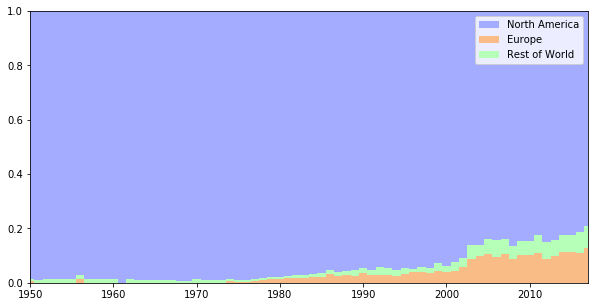

In [20]:
fig,ax = plt.subplots(figsize =(10,5))

barWidth = 1
r = range(1950,2018)

### Plot all countries not NA
plt.bar(r, testing_not_na, color='#b5ffb9',width=barWidth , label='Others')
# Plot only NA
plt.bar(r, testing_na, bottom=testing_not_na, color='#a3acff', width=barWidth, label='North America')
# Plot only EU
plt.bar(r, testing_eur, color='#f9bc86', width=barWidth, label = 'Europe')
plt.ylim([0,1]); plt.xlim([1950,2017])
plt.legend()

handles, labels = ax.get_legend_handles_labels()
ax.legend([handles[1], handles[2], handles[0]], ['North America', 'Europe', 'Rest of World'])

## Best Players

In [21]:
top_5 = ['PER', 'TS%', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'OWS', 'DWS', 'WS/48', 
         'OBPM', 'DBPM','BPM', 'VORP', 'eFG%', 'FT', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'PTS']
bottom_5= ['TOV', 'PF']

In [22]:
best_by_year= []

for year in range(2013,2018):
    newer_seasons = season_stats.loc[season_stats['Year']==year]
    top_players= []
    for top in top_5:
        top_players.append(list(newer_seasons.loc[:,['Player', top]].sort_values(top, 
                        ascending = False).reset_index(drop=True).loc[:5].Player))
    for bottom in bottom_5:
        top_players.append(list(newer_seasons.loc[:,['Player', bottom]].sort_values(bottom, 
                        ascending = True).reset_index(drop=True).loc[:5].Player))
    best_by_year.append(top_players)

In [27]:
combined_best = [np.concatenate(x) for x in best_by_year]
specialized_pwl = players_with_location.loc[:, ['Player', 'height', 'weight', 'born', 'Continents']]

In [59]:
combined_best_attr = []
continent_best = []

for ind, players in enumerate(combined_best, 2013):
    yearly = []
    conts = []
    for player in players:
        row = specialized_pwl.loc[specialized_pwl['Player']==player].values[0]
        yearly.append(np.array([row[1], row[2], ind-row[3]]))
        conts.append(row[4])
    continent_best.append(conts)
    combined_best_attr.append(yearly)

In [62]:
player_avg = []
for i in combined_best_attr:
    total = np.array([0.0,0.0,0.0])
    for j in i:
        total+=j
    total /=len(i)
    player_avg.append(total)

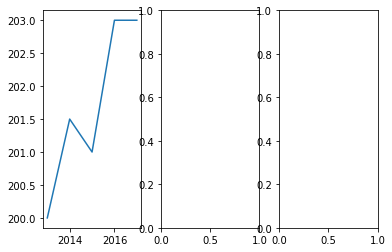

In [68]:
fig, ax = plt.subplots(1,3)

ax[0].plot(np.arange(2013,2018), [200, 201.5, 201, 203, 203])

In [66]:
player_avg

[array([201.78571429, 102.375     ,  28.39285714]),
 array([202.61309524, 103.45833333,  28.19047619]),
 array([203.20238095, 104.80952381,  28.08928571]),
 array([199.55357143, 100.86904762,  28.00595238]),
 array([202.52380952, 103.89285714,  29.13095238])]

## Salaries

In [69]:
salaries = pd.read_csv('nba-players-stats/NBASalaryData03-17.csv').dropna(subset=['salary', 'position'])

In [70]:
salaries = salaries.loc[salaries['position']!=' NA']
salaries.loc[:,'position'] = [x[-1] for x in salaries.position]
salaries.loc[:,'season'] = [x[5:] for x in salaries.season]

In [71]:
pivot = pd.pivot_table(salaries.iloc[:,[0,1,3,4]], values = 'salary', 
                       index= 'season', columns = 'position', aggfunc = np.mean)
yearly_sal = pivot.reset_index()

pivot_all = pd.pivot_table(salaries.iloc[:,[0,1,3,4]], values = 'salary', 
                       index= 'season', aggfunc = np.mean)
yearly_sal_all = pivot_all.reset_index()

In [72]:
def millions(x, pos):
    'The two args are the value and tick position'
    return '$%1.1fM' % (x*1e-6)

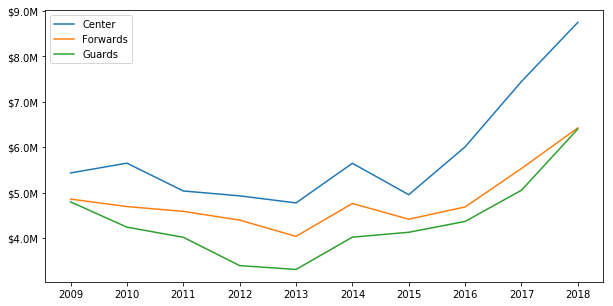

In [73]:
fig, ax = plt.subplots(figsize=(10,5))

formatter = FuncFormatter(millions)
ax.yaxis.set_major_formatter(formatter)

plt.plot(yearly_sal.season[-10:], yearly_sal.C[-10:], label ='Center')
plt.plot(yearly_sal.season[-10:], yearly_sal.F[-10:], label ='Forwards')
plt.plot(yearly_sal.season[-10:], yearly_sal.G[-10:], label ='Guards')
plt.legend()

In [74]:
salaries_loc= pd.merge(salaries, seasons_with_location.iloc[:,[1,-4,-3,-2,-1]], 
                       left_on = 'player', right_on='Player', how='left').drop_duplicates()

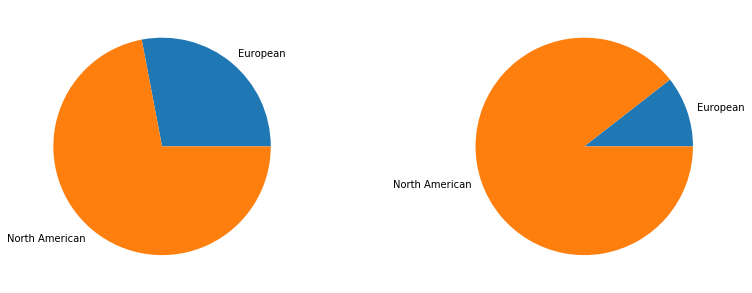

In [75]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

plt.subplots_adjust(right=1.2)

ax[0].pie([7,18], labels=['European', 'North American'])
ax[1].pie([np.mean(testing_eur[-10:]),1-np.mean(testing_eur[-10:])], labels=['European', 'North American'])
plt.show()

Text(0.5, 1.0, 'Eur')

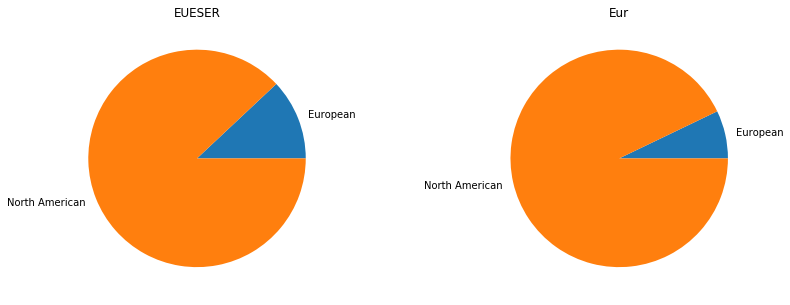

In [76]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

plt.subplots_adjust(right=1.2)

ax[0].pie([3,22], labels=['European', 'North American'])
ax[0].title.set_text('EUESER')
ax[1].pie([np.mean(testing_eur[-20:-10]),1-np.mean(testing_eur[-20:-10])], labels=['European', 'North American'])
plt.title('Eur')